# UBER Data Analytics Challenge

# Part 1: SQL Syntax
**[2 points]**

Given the below subset of Uber’s schema, write executable SQL queries to answer the questions below.
Please answer in a single query for each question and assume read only access to the database (i.e. do not use CREATE TABLE).


**Table Name: trips**

| Column          | Datatype                                     |
|-----------------|----------------------------------------------|
| id              | integer                                      |
| client_id       | integer (Foreign keyed to events.rider_id)   |
| driver_id       | integer                                      |
| city_id         | integer (Foreign keyed to cities.city_id)    |
| client_rating   | integer                                      |
| driver_rating   | integer                                      |
| request_at      | Timestamp with timezone                      |
| predicted_eta   | Integer                                      |
| actual_eta      | Integer                                      |
| status          | Enum('completed', 'cancelled_by_driver', 'cancelled_by_client')|

**Table Name: cities**

| Column    | Datatype |
|-----------|----------|
| city_id   | integer  |
| city_name | string   |

**Table Name: events**

| Column      | Datatype                                     |
|-------------|----------------------------------------------|
| device_id   | integer                                      |
| rider_id    | integer                                      |
| city_id     | integer                                      |
| event_name  | Enum('sign_up_success', 'attempted_sign_up', 'sign_up_failure')|
| _ts         | Timestamp with timezone                      |


## 1. For each of the cities 'Qarth' and 'Meereen', calculate 90th percentile difference between Actual and Predicted ETA for all completed trips within the last 30 days.

I am assuming each of the cities means we want to see 90th percentile difference on 2 different cities instead of combining results from the two

   ```SQl
    -- SQL Query for Question 1
    SELECT 
        c.city_name,
        percentile_cont(0.9) WITHIN GROUP (ORDER BY t.actual_eta - t.predicted_eta) AS "90th Percentile Difference"
    FROM 
        trips AS t
    LEFT JOIN
        cities AS c ON t.city_id = c.city_id
    WHERE
        c.city_name IN ('Qarth', 'Meereen')
        AND t.status = 'completed'
        AND t.request_at >= CURRENT_TIMESTAMP - INTERVAL '30 days'
    GROUP BY
        c.city_name
        ;
    ```

## 2. A signup is defined as an event labeled ‘sign_up_success’ within the events table. For each city (‘Qarth’ and ‘Meereen’) and each day of the week, determine the percentage of signups in the first week of 2016 that resulted in completed a trip within 168 hours of the sign up date.

   ```mysql
    -- MySql Query for Question 2
    WITH num_clients AS (
    -- Find count of all distinct rider/clients in 'Qarth' or 'Meereen' in the first week of 2016
    -- that completed a trip within 168 hours of the sign-up date
        SELECT
            c.city_name,
            WEEKDAY(e._ts) AS weekdays,
            COUNT(DISTINCT e.rider_id) AS total_clients
        FROM
            events e
        LEFT JOIN
            cities c ON e.city_id = c.city_id
        LEFT JOIN
            trips t ON e.rider_id = t.client_id
        WHERE
            EXTRACT(year FROM e._ts) = 2016
            AND WEEKOFYEAR(e._ts) = 1
            AND c.city_name IN ('Qarth', 'Meereen')
            AND t.request_at <= e._ts + INTERVAL '168 hours'
        GROUP BY 1, 2
    ),
    
    sucessful_clients AS (
    -- Find count of all distinct rider/clients in 'Qarth' or 'Meereen' in the first week of 2016
    -- that completed a trip within 168 hours of the sign-up date
    -- and were successful
        SELECT
            c.city_name,
            WEEKDAY(e._ts) AS weekdays,
            COUNT(DISTINCT e.rider_id) AS success_clients
        FROM
            events e
        LEFT JOIN
            cities c ON e.city_id = c.city_id
        LEFT JOIN
            trips t ON e.rider_id = t.client_id
        WHERE
            e.event_name = 'sign_up_success'
            AND EXTRACT(year FROM e._ts) = 2016
            AND WEEKOFYEAR(e._ts) = 1
            AND c.city_name IN ('Qarth', 'Meereen')
            AND t.request_at <= e._ts + INTERVAL '168 hours'
        GROUP BY 1, 2
    )
    -- find the percentage by diving successful clients / total clients
        SELECT
            n.city_name,
            s.weekdays,
            CONCAT(ROUND((s.success_clients * 1.0 / n.total_clients) * 100, 2), '%') AS "Percentage of Completed Trips"
        FROM
            num_clients n
        JOIN
            sucessful_clients s ON n.city_name = s.city_name and n.weekdays = s.weekdays
            ;
    
    ```

# Part 2: Experiment and metrics design
**[3 points]**

The Driver Experience team has just finished redesigning the Uber Partner app. The new version
expands the purpose of the app beyond just driving. It includes additional information on earnings,
ratings, and provides a unified platform for Uber to communicate with its partners.

1. Propose and define the primary success metric of the redesigned app. What are 2-3 additional tracking metrics that will be important to monitor in addition to the success metric defined above?

3 minutes brainstorm answer:
- earnings
    1. Earnings per Miles/Time Spent for driver in different cities
    2. Sales/Profit per ride/ per hour
    3. Somethings to do with status
        a. how cancellation affect earnings
- ratings
    1. ratings vs cancellation in different combination
- data from current schemas
    1. signup failures that result in no signups
    2. attemps signup to be successful 

2. Outline a testing plan to evaluate if redesigned app performs better (according to the metrics you outlined). How would you balance the need to deliver quick results, with statistical rigor, and while still monitoring for risks?

3 minutes brainstorm answer:

1. Pre-launch Baseline Assessment
2. A/B Testing
3. Statistical Analysis on control vs varient groups
4. User and driver feedbacks
5. Risk monitoring abnormal results/metrics and risk compensation for drivers/clients
6. Compare and contrast long term results vs baseline
7. Implement positive feedbacks based on surveys and statiscal inferences
8. Identify long term risk to reward ratio on implementations
8. Communicate to stakeholders

3. Explain how you would translate the results from the testing plan into a decision on whether to launch the new design or roll it back.

3 minutes brainstorm answer:

1. Monitor statistical analysis/confidence intervals and user/driver feedbacks
2. Identify change in trends on KPIs
3. Assess risk and monitor effectiveness of risk mitigation
4. Positive trend/outcomes while risk under certain threshold over long haul then launch else roll back
5. Communicate to stakeholders

# Part 3: Data Analysis
**[5 points]**

Uber’s Driver team is interested in predicting which driver signups are most likely to start driving. To help
explore this question, we have provided a sample dataset of a cohort of driver signups in January 2015. 1
The data was pulled a few months after they signed up to include the result of whether they actually
completed their first trip. It also includes several pieces of background information gather about the driver
and their car.

We would like you to use this data set to help understand what factors are best at predicting whether a
signup will start to drive, and offer suggestions to operationalize those insights to help Uber.
See below for a detailed description of the dataset. Please include any code you wrote for the analysis
and delete the dataset when you have finished with the challenge. Please also call out any data related
assumptions or issues that you encounter.

## Data Description:

- **id:** driver_id
- **city_name:** city this user signed up in
- **signup_os:** signup device of the user (“android”, “ios”, “website”, “other”)
- **signup_channel:** what channel did the driver sign up from (“offline”, “paid”, “organic”, “referral”)
- **signup_timestamp:** timestamp of account creation; local time in the form ‘YYYY-MM-DD’
- **bgc_date:** date of background check consent; in the form ‘YYYY-MM-DD’
- **vehicle_added_date:** date when driver’s vehicle information was uploaded; in the form ‘YYYY-MM-DD’
- **first_completed_date:** date of the first trip as a driver; in the form ‘YYYY-MM-DD’
- **vehicle_make:** make of vehicle uploaded (i.e. Honda, Ford, Kia)
- **vehicle_model:** model of vehicle uploaded (i.e. Accord, Prius, 350z)
- **vehicle_year:** year that the car was made; in the form ‘YYYY’


## Importing Packages

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

## 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip? (2 points)

11.22% took the first trip after signups

In the data preprocessing for logistic regression, I initially adjusted column data types and replaced abnormal values with NaN. Subsequently, missing values were imputed based on column distributions, and data engineering was performed on signup, background check, and vehicle-added dates. Dummy variables were created for categorical features, and irrelevant columns were dropped to enhance the dataset for logistic regression analysis.

In [2]:
df0 = pd.read_csv('ds_challenge_v2_1_data.csv')
df = df0.copy()

In [3]:
drive_percentage = df['first_completed_date'].count() / df['signup_date'].count()
print(f'Q1: {drive_percentage:.2%} took the first trip after signups')

Q1: 11.22% took the first trip after signups


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    54681 non-null  int64  
 1   city_name             54681 non-null  object 
 2   signup_os             47824 non-null  object 
 3   signup_channel        54681 non-null  object 
 4   signup_date           54681 non-null  object 
 5   bgc_date              32896 non-null  object 
 6   vehicle_added_date    13134 non-null  object 
 7   vehicle_make          13223 non-null  object 
 8   vehicle_model         13223 non-null  object 
 9   vehicle_year          13223 non-null  float64
 10  first_completed_date  6137 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.6+ MB


In [5]:
# convert datetype to datetime
date = ['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date']
for i in date:
    df[i] = pd.to_datetime(df[i])

# replace value to NaN
df['vehicle_year'] = df['vehicle_year'].replace(to_replace= 0, value=np.NaN)

In [6]:
def fill_na_based_on_distribution(column):
    """
    Filling null values base on distribution from its own column
    """
    non_null_values = column.dropna()
    nan_count = column.isnull().sum()

    if nan_count == 0:
        return column

    random_samples = np.random.choice(non_null_values, nan_count)
    column[column.isnull()] = random_samples

    return column

df['signup_os'] = fill_na_based_on_distribution(df['signup_os'])
df['bgc_date'] = fill_na_based_on_distribution(df['bgc_date'])
df['vehicle_make'] = fill_na_based_on_distribution(df['vehicle_make'])
df['vehicle_added_date'] = fill_na_based_on_distribution(df['vehicle_added_date'])

# fill vehicle_model based on distribution on vehicle_make values
df['vehicle_model'] = df['vehicle_model'].fillna(df.groupby('vehicle_make')['vehicle_model'].transform('last'))

# fill vehicle_year based on distribution on vehicle_model values
df['vehicle_year'] = df['vehicle_year'].fillna(df.groupby('vehicle_model')['vehicle_year'].transform('last'))

C:\Users\guoha\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [7]:
# get days between 2 columns
df['signup_to_bgc'] = (df['bgc_date'] - df['signup_date']).dt.days
df['signup_to_vehicle_add'] = (df['bgc_date'] - df['vehicle_added_date']).dt.days

# Clip at 0 to prevent events before signups
df['signup_to_bgc'] = df['signup_to_bgc'].clip(lower=0)
df['signup_to_vehicle_add'] = df['signup_to_vehicle_add'].clip(lower=0)

# weekdays vs weekend
df['signup_weekday'] = df['bgc_date'].apply(lambda x: x.weekday() <= 4)

In [8]:
# dummy variables
df['dummy_first_completed_date'] = df['first_completed_date'].apply(lambda x: 0 if pd.notna(x) else 1)
df['dummy_signup_weekday'] = df['signup_weekday'].astype(int)

def create_dummy_variables(df, column_name, prefix=None):
    """
    Create dummy variables using get_dummies for a categorical column and concatenate them to the DataFrame.
    """
    # Create dummy variables
    df_dummies = pd.get_dummies(df[column_name], prefix=prefix or column_name, drop_first=True)

    # Concatenate dummy variables to the original DataFrame
    df = pd.concat([df, df_dummies.astype(int)], axis=1)

    return df

# usage:
df = create_dummy_variables(df, column_name='city_name', prefix='city')
df = create_dummy_variables(df, column_name='signup_os', prefix='os')
df = create_dummy_variables(df, column_name='signup_channel', prefix='channel')
df = create_dummy_variables(df, column_name='vehicle_make', prefix='make')
df = create_dummy_variables(df, column_name='vehicle_model', prefix='model')
df = create_dummy_variables(df, column_name='vehicle_year', prefix='year')

In [9]:
df.describe()

,id,vehicle_year,signup_to_bgc,signup_to_vehicle_add,dummy_first_completed_date,dummy_signup_weekday,city_Strark,city_Wrouver,os_ios web,os_mac,os_other,os_windows,channel_Paid,channel_Referral,make_Audi,make_Autobot,make_BMW,make_Bentley,make_Bicycle,make_Bike,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Dodge,make_Fiat,make_Ford,make_GMC,make_Honda,make_Hummer,make_Hyundai,make_Infiniti,make_Isuzu,make_Jaguar,make_Jeep,make_Kia,make_Land Rover,make_Lexus,make_Lincoln,make_Maserati,make_Mazda,make_Mercedes-Benz,make_Mercury,make_Mini,make_Mitsubishi,make_Nissan,make_Oldsmobile,make_Pontiac,make_Porsche,make_Saab,make_Saturn,make_Scion,make_Subaru,make_Suzuki,make_Tesla,make_Toyota,make_Volkswagen,make_Volvo,make_Walker,model_3-Sep,model_3-series,model_300,model_300 H,model_4-series Gran Coupe,model_4Runner,model_5-Sep,model_5-series,model_500,model_500L,model_500X,model_6-series Gran Coupe,model_7-series,model_A3,model_A4,model_A6,model_A8,model_ATS,model_Acadia,model_Accent,model_Accord,model_Accord Hybrid,model_Allroad,model_Altima,model_Altima Hybrid,model_Amanti,model_Armada,model_Aspen,model_Aura,model_Avalanche,model_Avalon,model_Avenger,model_Aveo,model_Aviator,model_Azera,model_Baja,model_Beetle,model_Bicycle,model_Blazer,model_Borrego,model_Bravada,model_C-Class,model_C-Max,model_C-Max Hybrid,model_CC,model_CLA-Class,model_CLK-Class,model_CLS-Class,model_CR-V,model_CT,model_CT Hybrid,model_CTS,model_CX-5,model_CX-7,model_CX-9,model_Cadenza,model_Caliber,model_Camaro,model_Camry,model_Camry Hybrid,model_Camry Solara,model_Canyon,model_Captiva,model_Caravan,model_Cavalier,model_Cayenne,model_Century,model_Charger,model_Cherokee,model_Civic,model_Civic Hybrid,model_Classic,model_Cobalt,model_Colorado,model_Commander,model_Compass,model_Continental,model_Cooper,model_Corolla,model_Countryman,model_Countryman S,model_Crosstour,model_Crown Victoria,model_Cruze,model_Cube,model_DTS,model_Dakota,model_Dart,model_DeVille,model_Delivery,model_Durango,model_E-150 Cargo - WAV,model_E-Class,model_ES,model_EX,model_Echo,model_Edge,model_Elantra,model_Element,model_Enclave,model_Encore,model_Endeavor,model_Entourage,model_Envoy,model_Equinox,model_Equus,model_Escalade,model_Escape,model_Escape Hybrid,model_Expedition,model_Explorer,model_F-150,model_F-250,model_F-350,model_F350,model_FJ Cruiser,model_FR-S,model_FX,model_Fiesta,model_Fit,model_Five Hundred,model_Flex,model_Focus,model_Forenza,model_Forester,model_Forte,model_Freestar,model_Freestyle,model_Frontier,model_Fusion,model_Fusion Hybrid,model_G Sedan,model_G3,model_G6,model_GL-Class,model_GLA-Class,model_GLI,model_GLK-Class,model_GS,model_GS Hybrid,model_GTI,model_GX,model_Galant,model_Genesis,model_Ghibli,model_Golf,model_Grand Am,model_Grand Caravan,model_Grand Cherokee,model_Grand Marquis,model_Grand Prix,model_Grand Vitara,model_H2,model_H3,model_HHR,model_HR-V,model_HS Hybrid,model_Highlander,model_I,model_ILX,model_IS,model_Impala,model_Impreza,model_Insight Hybrid,model_Ion,model_JX,model_Jetta,model_Jetta Hybrid,model_Jetta SportWagen,model_Journey,model_Juke,model_K900,model_Kizashi,model_L300,model_LEAF,model_LR4,model_LS,model_LX,model_LaCrosse,model_Lancer,model_Land Rover,model_LeSabre,model_Legacy,model_Liberty,model_Lucerne,model_M,model_M-Class,model_MAZDA2,model_MAZDA3,model_MAZDA5,model_MAZDA6,model_MDX,model_MKC,model_MKS,model_MKT,model_MKX,model_MKZ,model_ML 350,model_ML Class,model_MPV,model_Magnum,model_Malibu,model_Mariner,model_Matrix,model_Maxima,model_Metris,model_Mirage,model_Model S,model_Monterey,model_Montero,model_Mountaineer,model_Murano,model_Mustang,model_NX,model_Navigator,model_Navigator L,model_Neon,model_Nitro,model_Odyssey,model_Optima,model_Optimus Prime,model_Outback,model_Outlander,model_Outlook,model_PT Cruiser,model_Pacifica,model_Passat,model_Pathfinder,model_Patriot,model_Pilot,model_Prius,model_Prius C,model_Prius V,model_Prius+,model_Prizm,model_Protege,model_Q3,model_Q40,model_Q45,model_Q5,model_Q50,model_Q7,m

In [10]:
columns_to_drop = ['id', 'signup_date', 'bgc_date', 'vehicle_added_date', 'vehicle_year', 'first_completed_date', 'city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model']
df_final = df.drop(columns=columns_to_drop)

## 2. Build a predictive model to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. (2 points)

My approach:

After validating logistic regression assumptions and mitigating class imbalance through SMOTE, the model exhibited exceptional performance metrics: Accuracy of 90.86%, Precision of 95.48%, Recall of 94.16%, and AUC-ROC of 91.02%. Despite these results, a  concern arises from the violation of the independence assumption in 7% of variables.

Exploring alternative models like XGBoost and Random Forest should be in the picture, given their robustness, but I feel like this model is already very successful and it did not take long to run. Another thing I should consider for model selection beyond performance metrics are runtime, memory usage, and interpretability. I should have also looked at feature importance and potentially employing ensemble approaches for a comprehensive understanding of model dynamics.

**Assumption 1** - Appropriate outcome type (Must be categorical).

**Assumption 2** - Linearity of independent variables and log odds

**Assumption 3** - No strongly influential outliers

**Assumption 4** - Absence of multicollinearity

**Assumption 5** - Independence of observations

**Assumption 6** - Sufficiently large sample size

Assumption 1: Satisfied

Using df['dummy_first_completed_date'] = df['first_completed_date'].apply(lambda x: 0 if pd.notna(x) else 1)

Assumption 2: Satisfied

Please do not run this; very long run time

In [11]:
import os #saving plot

In [12]:
'''
save_dir = "."
# Get predicted probabilities and compute log-odds for 'driving' outcome
predicted_probabilities_driving = log_reg_model.predict_proba(X)[:, 0]  # Probability of outcome 'driving'
log_odds_driving = np.log(predicted_probabilities_driving / (1 - predicted_probabilities_driving))

# Create scatterplots for each independent variable against log-odds
for column in X.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(X[column], log_odds_driving)
    plt.xlabel(column)
    plt.ylabel('Log-Odds of Outcome (driving)')
    plt.title(f'Scatterplot: {column} vs. Log-Odds of Outcome (driving)')
    
    
    # Save the plot as an image
    plot_filename = os.path.join(save_dir, f'DrivingScatterplot_{column}.png')
    plt.savefig(plot_filename,format='png')
    plt.show()
    
    # Close the plot to release memory
    plt.close()
'''

'\nsave_dir = "."\n# Get predicted probabilities and compute log-odds for \'driving\' outcome\npredicted_probabilities_driving = log_reg_model.predict_proba(X)[:, 0]  # Probability of outcome \'driving\'\nlog_odds_driving = np.log(predicted_probabilities_driving / (1 - predicted_probabilities_driving))\n\n# Create scatterplots for each independent variable against log-odds\nfor column in X.columns:\n    plt.figure(figsize=(6, 4))\n    plt.scatter(X[column], log_odds_driving)\n    plt.xlabel(column)\n    plt.ylabel(\'Log-Odds of Outcome (driving)\')\n    plt.title(f\'Scatterplot: {column} vs. Log-Odds of Outcome (driving)\')\n    \n    \n    # Save the plot as an image\n    plot_filename = os.path.join(save_dir, f\'DrivingScatterplot_{column}.png\')\n    plt.savefig(plot_filename,format=\'png\')\n    plt.show()\n    \n    # Close the plot to release memory\n    plt.close()\n'

Assumption 3: Satisfied

In [13]:
df.describe()

,id,vehicle_year,signup_to_bgc,signup_to_vehicle_add,dummy_first_completed_date,dummy_signup_weekday,city_Strark,city_Wrouver,os_ios web,os_mac,os_other,os_windows,channel_Paid,channel_Referral,make_Audi,make_Autobot,make_BMW,make_Bentley,make_Bicycle,make_Bike,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Dodge,make_Fiat,make_Ford,make_GMC,make_Honda,make_Hummer,make_Hyundai,make_Infiniti,make_Isuzu,make_Jaguar,make_Jeep,make_Kia,make_Land Rover,make_Lexus,make_Lincoln,make_Maserati,make_Mazda,make_Mercedes-Benz,make_Mercury,make_Mini,make_Mitsubishi,make_Nissan,make_Oldsmobile,make_Pontiac,make_Porsche,make_Saab,make_Saturn,make_Scion,make_Subaru,make_Suzuki,make_Tesla,make_Toyota,make_Volkswagen,make_Volvo,make_Walker,model_3-Sep,model_3-series,model_300,model_300 H,model_4-series Gran Coupe,model_4Runner,model_5-Sep,model_5-series,model_500,model_500L,model_500X,model_6-series Gran Coupe,model_7-series,model_A3,model_A4,model_A6,model_A8,model_ATS,model_Acadia,model_Accent,model_Accord,model_Accord Hybrid,model_Allroad,model_Altima,model_Altima Hybrid,model_Amanti,model_Armada,model_Aspen,model_Aura,model_Avalanche,model_Avalon,model_Avenger,model_Aveo,model_Aviator,model_Azera,model_Baja,model_Beetle,model_Bicycle,model_Blazer,model_Borrego,model_Bravada,model_C-Class,model_C-Max,model_C-Max Hybrid,model_CC,model_CLA-Class,model_CLK-Class,model_CLS-Class,model_CR-V,model_CT,model_CT Hybrid,model_CTS,model_CX-5,model_CX-7,model_CX-9,model_Cadenza,model_Caliber,model_Camaro,model_Camry,model_Camry Hybrid,model_Camry Solara,model_Canyon,model_Captiva,model_Caravan,model_Cavalier,model_Cayenne,model_Century,model_Charger,model_Cherokee,model_Civic,model_Civic Hybrid,model_Classic,model_Cobalt,model_Colorado,model_Commander,model_Compass,model_Continental,model_Cooper,model_Corolla,model_Countryman,model_Countryman S,model_Crosstour,model_Crown Victoria,model_Cruze,model_Cube,model_DTS,model_Dakota,model_Dart,model_DeVille,model_Delivery,model_Durango,model_E-150 Cargo - WAV,model_E-Class,model_ES,model_EX,model_Echo,model_Edge,model_Elantra,model_Element,model_Enclave,model_Encore,model_Endeavor,model_Entourage,model_Envoy,model_Equinox,model_Equus,model_Escalade,model_Escape,model_Escape Hybrid,model_Expedition,model_Explorer,model_F-150,model_F-250,model_F-350,model_F350,model_FJ Cruiser,model_FR-S,model_FX,model_Fiesta,model_Fit,model_Five Hundred,model_Flex,model_Focus,model_Forenza,model_Forester,model_Forte,model_Freestar,model_Freestyle,model_Frontier,model_Fusion,model_Fusion Hybrid,model_G Sedan,model_G3,model_G6,model_GL-Class,model_GLA-Class,model_GLI,model_GLK-Class,model_GS,model_GS Hybrid,model_GTI,model_GX,model_Galant,model_Genesis,model_Ghibli,model_Golf,model_Grand Am,model_Grand Caravan,model_Grand Cherokee,model_Grand Marquis,model_Grand Prix,model_Grand Vitara,model_H2,model_H3,model_HHR,model_HR-V,model_HS Hybrid,model_Highlander,model_I,model_ILX,model_IS,model_Impala,model_Impreza,model_Insight Hybrid,model_Ion,model_JX,model_Jetta,model_Jetta Hybrid,model_Jetta SportWagen,model_Journey,model_Juke,model_K900,model_Kizashi,model_L300,model_LEAF,model_LR4,model_LS,model_LX,model_LaCrosse,model_Lancer,model_Land Rover,model_LeSabre,model_Legacy,model_Liberty,model_Lucerne,model_M,model_M-Class,model_MAZDA2,model_MAZDA3,model_MAZDA5,model_MAZDA6,model_MDX,model_MKC,model_MKS,model_MKT,model_MKX,model_MKZ,model_ML 350,model_ML Class,model_MPV,model_Magnum,model_Malibu,model_Mariner,model_Matrix,model_Maxima,model_Metris,model_Mirage,model_Model S,model_Monterey,model_Montero,model_Mountaineer,model_Murano,model_Mustang,model_NX,model_Navigator,model_Navigator L,model_Neon,model_Nitro,model_Odyssey,model_Optima,model_Optimus Prime,model_Outback,model_Outlander,model_Outlook,model_PT Cruiser,model_Pacifica,model_Passat,model_Pathfinder,model_Patriot,model_Pilot,model_Prius,model_Prius C,model_Prius V,model_Prius+,model_Prizm,model_Protege,model_Q3,model_Q40,model_Q45,model_Q5,model_Q50,model_Q7,m

Assumption 4: Satisfied

In [14]:
# Identify continuos columns
numerical_columns = df_final.select_dtypes(include=['float64', 'int64']).columns

# VIF is the measure of the amount of multicollinearity in a set of multiple regression variables
X1 = df_final[numerical_columns]
vif = pd.DataFrame()
vif["Variable"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif

,Variable,VIF
0,signup_to_bgc,2.547885
1,signup_to_vehicle_add,1.632019
2,dummy_first_completed_date,2.059816


Assumption 5: Only a few variables violate independence so I would ignore it and say it is satisfied

In [15]:
categorical_columns = df0.select_dtypes(include='object').columns

# Create a list to store results
chi2_results = []

# Set your significance level
significance_level = 0.05

# Perform Chi-Square Test for each pair of categorical variables
for i in range(len(categorical_columns) - 1):
    for j in range(i + 1, len(categorical_columns)):
        contingency_table = pd.crosstab(df0[categorical_columns[i]], df0[categorical_columns[j]])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Check if p-value is greater than or equal to the significance level
        if p >= significance_level:
            # Store results in a dictionary
            result = {
                'Variable1': categorical_columns[i],
                'Variable2': categorical_columns[j],
                'Chi2': chi2,
                'P-value': p,
            }
            
            chi2_results.append(result)

# Create a DataFrame from the results
significant_results_df = pd.DataFrame(chi2_results)

# Display the results
print(significant_results_df)

       Variable1             Variable2          Chi2   P-value
0      city_name              bgc_date    149.672818  0.400480
1      city_name    vehicle_added_date    182.299641  0.059310
2    signup_date          vehicle_make   1369.796045  0.103670
3       bgc_date          vehicle_make   2890.799284  0.946663
4   vehicle_make  first_completed_date   2455.090156  0.247058
5  vehicle_model  first_completed_date  17297.647308  0.629849


Addressing Class Imbalance using SMOTE

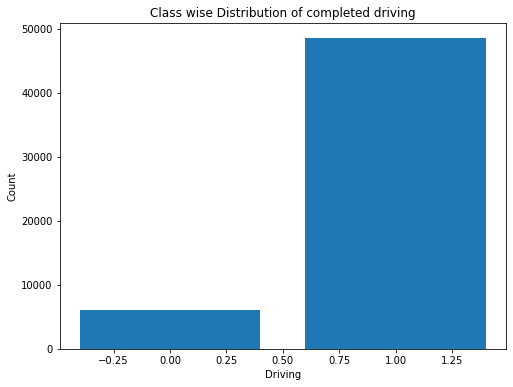

1    48544
0     6137
Name: dummy_first_completed_date, dtype: int64

In [16]:
# Count the values in outcome column
class_counts = df['dummy_first_completed_date'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Driving')
plt.ylabel('Count')
plt.title('Class wise Distribution of completed driving')
plt.show()
class_counts

In [17]:
# Isolate X variables
X = df_final.drop('dummy_first_completed_date', axis=1)

# Isolate y variable
y = df_final['dummy_first_completed_date']

# Split into train and test sets
X_interim, X_test, y_interim, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_interim, y_interim, test_size=0.25, stratify=y_interim, random_state=42)

# Initialize the SMOTE oversampler
smote = SMOTE(random_state=42)

# Fit and apply the oversampler to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print the original and resampled dataset shapes
print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_train_smote))

Original dataset shape: Counter({1: 29126, 0: 3682})
Resampled dataset shape: Counter({0: 29126, 1: 29126})


Assumption 6: Satisfied

In [18]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (32808, 446)
Shape of X_test: (10937, 446)
Shape of X_val: (10936, 446)


## GridSearch

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define the parameter grid including 'logistic_regression__C'
grid = {
    "logistic_regression__C": [1, 5],  # Adjusted C parameter for logistic regression
    "logistic_regression__solver": ['liblinear']
}

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=100, random_state=42))  # Increased max_iter
])

# Create GridSearchCV
log_reg_model_cv = GridSearchCV(pipeline, grid, cv=5, scoring='precision')

In [20]:
%%time
# Fit the model to the training dataset
log_reg_model_cv.fit(X_train_smote, y_train_smote)

Wall time: 3min 21s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic_regression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logistic_regression__C': [1, 5],
                         'logistic_regression__solver': ['liblinear']},
             scoring='precision')

In [21]:
# Now, you can use the trained model to make predictions on the validation set
y_val_pred = log_reg_model_cv.predict(X_val)

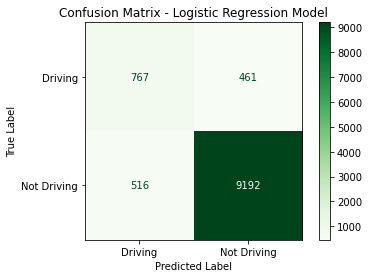

In [22]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Create a ConfusionMatrixDisplay object and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Driving", "Not Driving"])
disp.plot(cmap='Greens')

# Add title and axis labels
plt.title("Confusion Matrix - Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

## Model Performance Interpretation

- **True Positive (TP):** The model correctly predicted 795 drivers who actually drove.
  
- **True Negative (TN):** The model correctly predicted 9141 drivers who actually did not drove.
  
- **False Positive (FP):** The model incorrectly predicted 433 drivers as leaving the company when they actually drove(Type I error).
  
- **False Negative (FN):** The model incorrectly predicted 567 drivers as staying in the company when they actually did not drove(Type II error).

## Evaluation Metrics

Now, we can use these values to calculate various evaluation metrics, providing a comprehensive understanding of the logistic regression model's performance.

- **Accuracy:** The proportion of correctly classified instances among the total predictions.
  
- **Precision:** The proportion of true positives among the instances predicted as positive, indicating the accuracy of positive predictions.
  
- **Recall (Sensitivity):** The proportion of true positives among the actual positive instances, indicating the model's ability to capture all positive instances.
  
- **F1-score:** The harmonic mean of precision and recall, providing a balanced measure of a model's performance.

These metrics offer valuable insights into the effectiveness of the logistic regression model in predicting employee retention or departure.


In [23]:
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1228
           1       0.95      0.95      0.95      9708

    accuracy                           0.91     10936
   macro avg       0.78      0.79      0.78     10936
weighted avg       0.91      0.91      0.91     10936



# Summary

Assumption 1 is satisfied by creating a dummy "first completed date" variable, where if a value exists in the column, it is set to 1, otherwise, it is 0. Assumption 2 is satisfied by creating scatterplots for each independent variable against log-odds. Assumption 3 is satisfied by observing values using df.describe(). However, this could have been improved by utilizing winsorizing, which limits extreme values by setting all data below/above the x-th percentile to that percentile.

Assumption 4 is satisfied by using VIF, which measures the amount of multicollinearity in a set of multiple regression variables. Assumption 5 is satisfied by calculating the chi-squared test with a significance level of 0.05. Assumption 6 is satisfied by observing that we have over 1000 data points for our model.

In addition to ensuring all assumptions are met for accurate results, I had to use the SMOTE oversampler to address class imbalance. I also chose to use StandardScaler to transform my data to be more normally distributed, which is a common practice. However, this turned out to be a significant challenge. Using StandardScaler assumes that the dataset follows a normal distribution, which was not the case. Furthermore, using oversampling presented scalability issues, as StandardScaler does not work well with large data volumes and is sensitive to outliers, which my dataset contained. This highlights the importance of thorough exploratory data analysis (EDA) and visualizations, which I neglected due to overconfidence in the dataset's simplicity.

Ultimately, I believed my data was prepared with all assumptions satisfied and applied transformations that I thought were sophisticated. I used logistic regression with GridSearchCV from sklearn, evaluating the precision, recall, and F1-score from the classification report to determine the model's suitability and deployability. However, the model performed poorly in predicting whether the driver would drive, although it excelled in predicting when the driver would not drive. Since the business priority is predicting whether the driver will drive, this renders the model inadequate. To improve it, I should consider adding more parameters to the grid search, although this may increase runtime significantly. Additionally, further data engineering is necessary, as the transformation of my data seems flawed.